<a href="https://colab.research.google.com/github/Elieser1945/DeepLearning/blob/main/RNN_Model_PyTorch_Dengan_DeteksiSarkasme_json.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **📌 RNN Model PyTorch Dengan DeteksiSarkasme.json**

# Instalasi Library

In [1]:
!pip install torch torchvision torchaudio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

# Import Library

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import json


In [3]:
# GPU support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


# Load Dataset

In [4]:
import json

data = []
with open('/content/DeteksiSarkasme.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))

# Contoh lihat isi
print(data[0])


{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5', 'headline': "former versace store clerk sues over secret 'black code' for minority shoppers", 'is_sarcastic': 0}


In [5]:
# Convert the loaded data to a DataFrame
df = pd.DataFrame(data)
display(df)


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
...,...,...,...
26704,https://www.huffingtonpost.com/entry/american-...,american politics in moral free-fall,0
26705,https://www.huffingtonpost.com/entry/americas-...,america's best 20 hikes,0
26706,https://www.huffingtonpost.com/entry/reparatio...,reparations and obama,0
26707,https://www.huffingtonpost.com/entry/israeli-b...,israeli ban targeting boycott supporters raise...,0


# Pre Processing

In [6]:
# Make sure the 'is_sarcastic' column is numeric
df['is_sarcastic'] = df['is_sarcastic'].astype(int)


In [7]:
# Preprocessing data
X = df['headline'].values
y = df['is_sarcastic'].values


In [8]:
# Convert text data into features using CountVectorizer
vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X_vec = vectorizer.fit_transform(X).toarray()

In [9]:

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)


In [10]:
# Reshape data to fit RNN (LSTM) requirements
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)  # Add sequence dimension
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)    # Add sequence dimension
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)


# Bangun Model RNN

In [11]:
# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Take the last hidden state
        out = self.fc(out)
        return self.softmax(out)


# Hyperparameter Tuning

In [12]:
# Hyperparameter tuning using GridSearch
param_grid = {
    'learning_rate': [0.0005, 0.01],
    'hidden_size': [64, 128],
    'num_layers': [1, 2]
}


In [13]:
# Custom function to train and evaluate the model
def train_and_evaluate(lr, hidden_size, num_layers):
    model = RNN(input_size=5000, hidden_size=hidden_size, output_size=2, num_layers=num_layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    epochs = 30
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs.data, 1)
        accuracy = 100 * (predicted == y_test_tensor).sum() / len(y_test_tensor)
        return accuracy.item()


In [14]:
# Perform Grid Search for hyperparameter tuning
best_accuracy = 0
best_params = None


In [15]:
from sklearn.model_selection import ParameterGrid  # Pastikan ini diimpor

# Iterate over the grid search combinations
for params in ParameterGrid(param_grid):
    lr = params['learning_rate']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']

    print(f"Training model with lr={lr}, hidden_size={hidden_size}, num_layers={num_layers}")
    accuracy = train_and_evaluate(lr, hidden_size, num_layers)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = (lr, hidden_size, num_layers)


Training model with lr=0.0005, hidden_size=64, num_layers=1
Training model with lr=0.0005, hidden_size=64, num_layers=2
Training model with lr=0.01, hidden_size=64, num_layers=1
Training model with lr=0.01, hidden_size=64, num_layers=2
Training model with lr=0.0005, hidden_size=128, num_layers=1
Training model with lr=0.0005, hidden_size=128, num_layers=2
Training model with lr=0.01, hidden_size=128, num_layers=1
Training model with lr=0.01, hidden_size=128, num_layers=2


In [16]:
print(f"Best Hyperparameters: {best_params} with accuracy: {best_accuracy}%")


Best Hyperparameters: (0.01, 128, 2) with accuracy: 77.29315185546875%


# Latih Model

In [27]:
# Train the best model with the best hyperparameters
best_lr, best_hidden_size, best_num_layers = best_params
best_model = RNN(input_size=5000, hidden_size=best_hidden_size, output_size=2, num_layers=best_num_layers).to(device)
optimizer = optim.Adam(best_model.parameters(), lr=best_lr)
criterion = nn.CrossEntropyLoss()

loss_history = []
accuracy_history = []


In [41]:
epochs = 20
for epoch in range(epochs):
    best_model.train()
    optimizer.zero_grad()
    outputs = best_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    _, predicted = torch.max(outputs.data, 1)
    total = y_train_tensor.size(0)
    correct = (predicted == y_train_tensor).sum().item()
    accuracy = 100 * correct / total

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [1/20], Loss: 0.3775
Epoch [2/20], Loss: 0.3775
Epoch [3/20], Loss: 0.3775
Epoch [4/20], Loss: 0.3775
Epoch [5/20], Loss: 0.3775
Epoch [6/20], Loss: 0.3775
Epoch [7/20], Loss: 0.3774
Epoch [8/20], Loss: 0.3774
Epoch [9/20], Loss: 0.3774
Epoch [10/20], Loss: 0.3773
Epoch [11/20], Loss: 0.3773
Epoch [12/20], Loss: 0.3773
Epoch [13/20], Loss: 0.3773
Epoch [14/20], Loss: 0.3773
Epoch [15/20], Loss: 0.3773
Epoch [16/20], Loss: 0.3773
Epoch [17/20], Loss: 0.3773
Epoch [18/20], Loss: 0.3773
Epoch [19/20], Loss: 0.3773
Epoch [20/20], Loss: 0.3773


# Evaluasi Model

Accuracy on test set: 77.01%


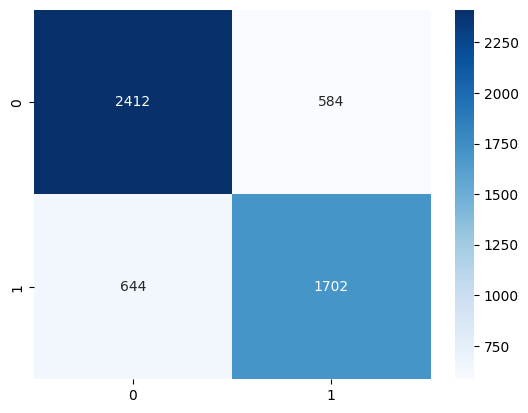

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      2996
           1       0.74      0.73      0.73      2346

    accuracy                           0.77      5342
   macro avg       0.77      0.77      0.77      5342
weighted avg       0.77      0.77      0.77      5342



In [38]:
# Evaluate the best model
best_model.eval()
with torch.no_grad():
    outputs = best_model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = 100 * (predicted == y_test_tensor).sum() / len(y_test_tensor)
    accuracy_history.append(accuracy.item())
    best_model.train()

    # Accuracy
    accuracy = 100 * (predicted == y_test_tensor).sum() / len(y_test_tensor)
    print(f'Accuracy on test set: {accuracy.item():.2f}%')

    # Confusion Matrix and Classification Report
    cm = confusion_matrix(y_test_tensor.cpu(), predicted.cpu())
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.show()

    print(classification_report(y_test_tensor.cpu(), predicted.cpu()))

-----Matriks Evaluasi-----
Accuracy: 0.7701
Precision: 0.7445
Recall: 0.7255
F1 Score: 0.7349
AUC: 0.8149


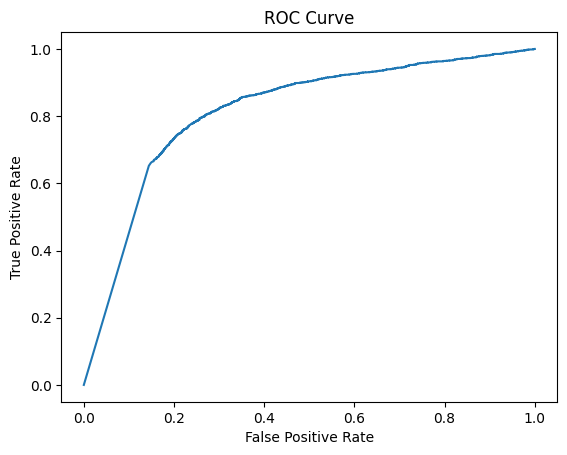

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve


# Evaluate the best model
best_model.eval()
with torch.no_grad():
        outputs = best_model(X_test_tensor)
        _, predicted = torch.max(outputs.data, 1)

        # Calculate metrics
        accuracy = accuracy_score(y_test_tensor.cpu(), predicted.cpu())
        precision = precision_score(y_test_tensor.cpu(), predicted.cpu())
        recall = recall_score(y_test_tensor.cpu(), predicted.cpu())
        f1 = f1_score(y_test_tensor.cpu(), predicted.cpu())

        # AUC and ROC need probability scores, not just predictions
        probabilities = outputs[:, 1].cpu()
        auc = roc_auc_score(y_test_tensor.cpu(), probabilities)
        fpr, tpr, thresholds = roc_curve(y_test_tensor.cpu(), probabilities)

        print("-----Matriks Evaluasi-----")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"AUC: {auc:.4f}")

        # Plot ROC curve
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.show()
